In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
#import matplotlib.pyplot as plt
import theano.tensor.slinalg as sla
from pymc3.distributions.transforms import t_stick_breaking
from pymc3 import math as pmmath
import seaborn as sns
from scipy.special import logsumexp 

/home/junpenglao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


***Use generative process to create toy data***

In [2]:
#
L = 5
N = 10
num_clusters = 3
num_values = 3

pi = pm.Dirichlet.dist(a=np.ones(num_clusters), shape=(num_clusters)).random()

theta_i = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                            shape=(num_clusters, num_values)).random()

theta_t = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                            shape=(num_clusters, num_values, num_values)).random()

In [3]:
data = []
clusters = []
for d in range(N):
    # draw a cluster
    #cluster = np.random.choice(num_cluster,p=pi)
    cluster = pm.Categorical.dist(pi).random(size=1)
    values = []
    # draw initial value
    #prev_value = np.random.choice(num_cluster,p=theta_i[cluster])
    prev_value = pm.Categorical.dist(theta_i[cluster]).random(size=1)
    values.append(prev_value)
    for l in range(L-1):
        # draw next value based on previous value
        #next_value = np.random.choice(num_cluster,p=theta_t[cluster,prev_value])
        next_value = pm.Categorical.dist(
            theta_t[cluster, prev_value]).random(size=1)
        values.append(prev_value)
        prev_value = next_value
    data.append(values)
    clusters.append(cluster)

In [4]:
# convert to matrix
data = np.asarray(data)
data

array([[2, 2, 0, 2, 0],
       [1, 1, 2, 0, 2],
       [0, 0, 2, 1, 1],
       [2, 2, 0, 0, 2],
       [1, 1, 2, 0, 2],
       [2, 2, 0, 2, 0],
       [1, 1, 2, 0, 2],
       [0, 0, 2, 2, 0],
       [0, 0, 2, 0, 2],
       [0, 0, 2, 1, 1]])

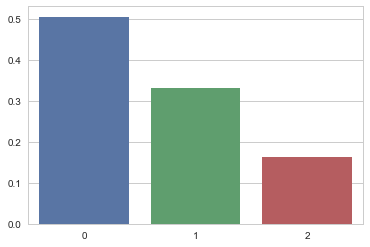

In [5]:
# plot cluster probabilities
sns.set(style="whitegrid")
sns.barplot(x=np.arange(3), y=pi);

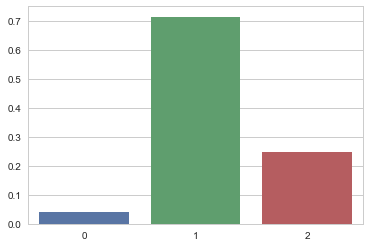

In [6]:
# initial probabilities for cluser 0
sns.barplot(x=np.arange(num_values), y=theta_i[0]);

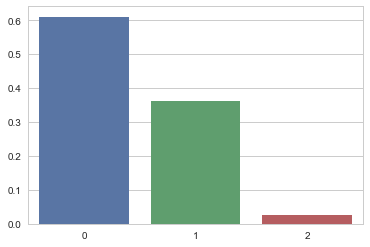

In [7]:
# initial probabilities for cluster 1
sns.barplot(x=np.arange(num_values), y=theta_i[1]);

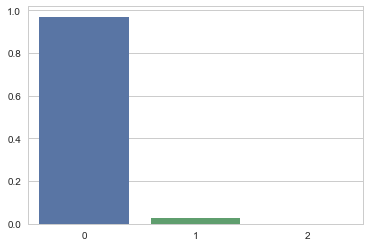

In [8]:
# initial probabilities for cluser 2
sns.barplot(x=np.arange(num_values), y=theta_i[2]);

In [9]:
# print assignments
clusters = np.asarray(clusters)
clusters

array([0, 0, 2, 0, 0, 0, 1, 1, 1, 2])

***Several tests to compare the log likelihood using regular python, numpy and theano****

In [10]:
# to compare computations wiht theano, transform data
data = data.astype("int32")
theta_i = theta_i.astype("float32")
theta_t = theta_t.astype("float32")
pi = pi.astype("float32")


# dirty way to compute likelihood of full data
l_data = []
for didx in range(len(data)):
    l_obs = []
    for pidx in range(3):
        trans = []
        for iidx in range(data[didx].shape[0]-1):
            trans.append(
                np.log(theta_t[pidx][data[didx, iidx], data[didx, iidx+1]]))
        l_obs.append(np.log(pi[pidx]) + np.log(theta_i[pidx]
                                               [data[didx, 0]]) + np.sum(trans))

    l_data.append(logsumexp(l_obs))
np.sum(l_data)

-66.38203

In [11]:
# same using numpy
t1 = np.log(pi)*np.ones((10, 1))
t2 = np.column_stack(np.log(theta_i[:, data[:, 0]]))
t3 = np.sum(np.log(theta_t[:, data[:, :-1], data[:, 1:]]), axis=2).T
l_obs = logsumexp(t1+t2+t3, axis=1)
np.sum(l_obs)

-66.38203305231723

In [12]:
# Same computations with theano
import theano
import theano.tensor as tt
import theano
theano.config.compute_test_value = "ignore"
theano.config.on_unused_input = 'ignore'

data = np.asarray(data)
tdata = tt.imatrix('tdata')
ttheta_i = tt.fmatrix('ttheta_i')
ttheta_t = tt.tensor3('ttheta_t')
tpi = tt.fvector('tpi')

# compute the full likelihood of data with theano
out = tt.sum(pmmath.logsumexp(tt.log(tpi)*tt.ones((10, 1)) +
                              tt.log(ttheta_i[:, tdata[:, 0]]).T +
                              tt.sum(tt.log(ttheta_t[:, tdata[:, :-1], tdata[:, 1:]]), axis=2).T, axis=1))
f = theano.function([tpi, ttheta_i, ttheta_t, tdata], out)
f(pi, theta_i, theta_t, data)

array(-66.38203485)

***Build bayesian model using pymc3***

In [13]:
# log likelihood
def log_data(pi, theta_init, theta_trans):
    def log_data_(docs):
        t1 = tt.log(pi)*tt.ones((10, 1))
        t2 = tt.log(theta_init[:, docs[:, 0]]).T
        t3 = tt.sum(theta_trans[:, docs[:, :-1], docs[:, 1:]], axis=2).T
        return tt.sum(pmmath.logsumexp(t1+t2+t3, axis=1))

    return log_data_

***Note***: the folowing throws an error 

In [14]:
with pm.Model() as model:
    # the posterior distribution of a multinomial with a dirichlet prior is another dirichlet prior
    pi = pm.Dirichlet('pi', a=pm.floatX((1.0 / num_clusters) * np.ones(num_clusters)),
                      shape=(num_clusters), transform=t_stick_breaking(1e-9))
    theta_i = pm.Dirichlet('theta_i', a=pm.floatX((1.0 / num_values) * np.ones((num_clusters, num_values))),
                           shape=(num_clusters, num_values), transform=t_stick_breaking(1e-9))

    theta_t = pm.Dirichlet('theta_t', a=pm.floatX((1.0 / num_values) * np.ones((num_clusters, num_values, num_values))),
                           shape=(num_clusters, num_values, num_values), transform=t_stick_breaking(1e-9))
    # how do we aggregate the likelihood of all the data
    obs = pm.DensityDist('obs', log_data(pi, theta_i, theta_t), observed=data)

TypeError: index must be integers

In [18]:
# log likelihood
def log_data2(pi, theta_init, theta_trans, docs):
    t1 = tt.log(pi)*tt.ones((10, 1))
    t2 = tt.log(theta_init[:, docs[:, 0]]).T
    t3 = tt.sum(theta_trans[:, docs[:, :-1], docs[:, 1:]], axis=2).T
    return tt.sum(pmmath.logsumexp(t1+t2+t3, axis=1))

In [16]:
with pm.Model() as model:
    # the posterior distribution of a multinomial with a dirichlet prior is another dirichlet prior
    pi = pm.Dirichlet('pi', 
                      a=pm.floatX((1.0 / num_clusters) * np.ones(num_clusters)),
                      shape=(num_clusters), 
                      transform=t_stick_breaking(1e-9))

    theta_i = pm.Dirichlet('theta_i', 
                           a=pm.floatX((1.0 / num_values) * np.ones((num_clusters, num_values))),
                           shape=(num_clusters, num_values), 
                           transform=t_stick_breaking(1e-9))

    theta_t = pm.Dirichlet('theta_t', 
                           a=pm.floatX((1.0 / num_values) * np.ones((num_clusters, num_values, num_values))),
                           shape=(num_clusters, num_values, num_values), 
                           transform=t_stick_breaking(1e-9))

    # how do we aggregate the likelihood of all the data
    obs = pm.Potential('obs', log_data2(pi, theta_i, theta_t, data))

For more information about using `Potential` or `DensityDist` see eg https://discourse.pymc.io/t/how-to-set-up-a-custom-likelihood-function-for-two-variables/906/6

In [17]:
with model:
    map1 = pm.find_MAP()
map1

logp = 354.69, ||grad|| = 0.0014682: 100%|██████████| 33/33 [00:00<00:00, 994.78it/s]  


{'pi_stickbreaking__': array([ 3.78111530e+01, -4.36856298e-05]),
 'theta_i_stickbreaking__': array([[ 3.56671026e-01,  2.52984702e-05],
        [ 5.52092135e+01, -5.88735623e-04],
        [ 5.52091996e+01, -5.88815902e-04]]),
 'theta_t_stickbreaking__': array([[[ -211.59862826, -1009.76971025],
         [ -706.97172163,   492.46613401],
         [  857.2059972 ,  -492.41810017]],
 
        [[ -211.59862718, -1009.76970873],
         [ -706.971721  ,   492.46613604],
         [  857.20599593,  -492.41810219]],
 
        [[ -211.59862718, -1009.76970873],
         [ -706.971721  ,   492.46613604],
         [  857.20599593,  -492.41810219]]]),
 'pi': array([9.99999999e-01, 4.99989120e-10, 5.00010963e-10]),
 'theta_i': array([[4.16665715e-01, 2.91670832e-01, 2.91663453e-01],
        [9.99999999e-01, 4.99852857e-10, 5.00147225e-10],
        [9.99999999e-01, 4.99852837e-10, 5.00147245e-10]]),
 'theta_t': array([[[1.00000000e-09, 9.99999999e-10, 9.99999998e-01],
         [1.00000000e-09, 9.9